# Welcome to CSE 276F, Assignment 3

In assignment 3, we will be exploring Reinforcement Learning. RL provides a general method for learning policies from reward functions. This assignment will start with some basic RL beginning with making a simple grid environemnt followed by solving it with Deep Q Networks (DQN). We will dive deeper into RL for robotics with algorithms like PPO/SAC in the next assignment

## Setup Code / Packages

If you are running code locally follow the installation instructions for ManiSkill here: https://maniskill.readthedocs.io/en/latest/user_guide/getting_started/installation.html. You will need a CUDA-enabled GPU on a Linux machine for assignments. Windows/Mac have more limited support but are useful if that is the local machine you have access to for local debugging. When building custom environments you can then use a GUI to explore environments which helps the development process.

If you are using UCSD Datahub you don't need to do any additional installation steps. You only need to run `pip install --upgrade mani_skill-nightly`

If you are using Google Colab make sure to run the two cells below to install all dependencies.

If you see an error such as

`ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject`

simply restart the notebook after running the installation commands.

In [ ]:
# setup vulkan
!mkdir -p /usr/share/vulkan/icd.d
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json
!mv nvidia_icd.json /usr/share/vulkan/icd.d
!mv 10_nvidia.json /usr/share/glvnd/egl_vendor.d/10_nvidia.json
!apt-get install -y --no-install-recommends libvulkan-dev
# dependencies
!pip install --upgrade mani_skill-nightly

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libvulkan1
Recommended packages:
  mesa-vulkan-drivers | vulkan-icd
The following NEW packages will be installed:
  libvulkan-dev libvulkan1
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,020 kB of archives.
After this operation, 17.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan1 amd64 1.3.204.1-2 [128 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan-dev amd64 1.3.204.1-2 [892 kB]
Fetched 1,020 kB in 2s (568 kB/s)
Selecting previously unselected package libvulkan1:amd64.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../libvulkan1_1.3.204.1-2_amd64.deb ...
Unpacking libvulkan1:amd64 (1.3.204.1-2) ...
Selecting previously unselected package libvulkan-dev:amd64.
Preparing to unpa

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    site.main() # run this so local pip installs are recognized

## 1 Basic RL Programming (10 pts)

This section will take you through the basics of RL programming/engineering and apply theory to practice.

### Problem 1.1: Building an environment, "Avoid the Lava" (3 pts)

We will start with building a simple and visualizable environment called AvoidLava where a controllable agent on a 2D grid of tiles that can be empty or lava, and must find its way to the goal from a starting location.

The standard environment interface is typically the [Gym/Gymnasium](https://gymnasium.farama.org/) interface. By adhering to this interface, a lot of RL libraries can work nearly out of the box on your custom environment. In the first assignment you had some experience using Gymnasium through ManiSkill. This section will task you to create a discrete action-space environment using Gymnasium alone without an additional framework.

---

For this task you need to implement the environment dynamics in the `step()` function, implement environment termination in `get_terminated()`, and implement your own reward function in `get_reward()`.

In the Avoid the Lava game, the agent can take 4 discrete actions labelled 0, 1, 2, 3 (go up, right, down, left) on a 2D grid map and the agent position changes to reflect the action taken.

If the agent tries to go to a map tile off screen (beyond the map size) nothing should happen, the agent position is unchanged.

If the agent takes an action that leads it to end up on a map tile that is on lava, `get_terminated()` should return True.


The reward function can be chosen by you, you must define it in `get_reward()`. This reward function must be sufficiently informative/dense such that the agent is encouraged to go towards the goal location and avoids losing due to falling in lava.

In [67]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from moviepy import ImageSequenceClip

# this map should be left unchanged
DEFAULT_LAVA_MAP = np.array([
    [0,3], [1, 1], [2, 1], [2, 3], [3, 3], [3, 4]
])
class AvoidLava(gym.Env):
    def __init__(self, map_size: int = 5, lava_positions = DEFAULT_LAVA_MAP, **kwargs):
        self.map_size = map_size
        # define obs and action space to let libraries know what to expect as observation data
        # and what to provide as action data. We do this for you.
        self.lava_positions = lava_positions.copy()
        self.observation_space = gym.spaces.Box(0, map_size, shape=(2, ))
        self.action_space = gym.spaces.Discrete(4)
    def reset(self, seed=None, options=None):
        # reset the environment by generating a new map, goal location
        # and spawn agent at a fixed start location
        self.map_state = np.zeros((self.map_size, self.map_size))
        self.agent_pos = np.zeros(2, dtype=int)
        self.goal_pos = np.array([
            0, 4
        ])

        return self.get_obs(), {}

    def get_obs(self):
        return self.agent_pos.copy()
    
    def get_terminated(self):
        ### your code goes below ###
        # Implement the env termination function, should return True/False
        # return True if the agent is on lava
        on_lava = np.any((self.lava_positions == self.agent_pos).all(axis=1))
        return on_lava
        ### your code goes above ###


    def get_reward(self):
        ### your code goes below ###
        # Write the env reward function, should return a float ###
        on_lava = self.get_terminated()
        # penalty for being on lava
        if on_lava:
            return -100.0
        # reward for reaching goal
        if np.array_equal(self.agent_pos, self.goal_pos):
            return 200.0
        
        return 1.0 # reward for moving
        ### your code goes above ###


    def step(self, action):
        ### your code goes below ###
        # Write the AvoidLava dynamics function below ###
        # You can do it by simply updating self.agent_pos appropriately

        # action definition. (0, 0) is bottom left, (self.map_size - 1, self.map_size) is top right corner of the map.
        # 0: go up
        # 1: go right
        # 2: go down
        # 3: go left
        next_pos = None
        # up
        if action == 0:
            next_pos = self.agent_pos + np.array([0, 1])
        # right
        elif action == 1:
            next_pos = self.agent_pos + np.array([1, 0])
        # down
        elif action == 2:
            next_pos = self.agent_pos + np.array([0, -1])
        # left
        elif action == 3:
            next_pos = self.agent_pos + np.array([-1, 0])
        else:
            raise ValueError(f"Invalid action: {action}")
        
        # check if next_pos is out of bounds
        if (0 <= next_pos[0] < self.map_size and  0 <= next_pos[1] < self.map_size):
            self.agent_pos = next_pos
        ### your code goes above ###

        truncated = False
        return self.get_obs(), self.get_reward(), self.get_terminated(), truncated, {}
    
    def render(self):
        # very simple visualization code which returns a RGB array to visualize
        # the current state
        scale = 32
        img = np.zeros((self.map_size * scale, self.map_size * scale, 3), dtype=int) + 255
        def draw_cube(x, y, color, l=1):
          img[img.shape[0] - scale - y*scale:img.shape[0] - scale-y*scale+l, x*scale:x*scale+l] = color
        for lava_pos in self.lava_positions:
            draw_cube(lava_pos[0], lava_pos[1], color=np.array([252, 81, 48]), l=scale)
        draw_cube(self.goal_pos[0], self.goal_pos[1], color=np.array([35, 187, 74]), l=scale)
        k = scale//2
        img[img.shape[0] - self.agent_pos[1]*scale-2*k+k//2:img.shape[0] - self.agent_pos[1]*scale-k+k//2,
            self.agent_pos[0]*scale+k//2:self.agent_pos[0]*scale+k+k//2] = np.array([25, 146, 237])
        return img

# Code below is just for recording videos to watch agents play the game
def record_episode(imgs, file, fps=5):
    from pathlib import Path
    import os.path as osp
    Path(osp.dirname(file)).mkdir(exist_ok=True, parents=True)
    clip = ImageSequenceClip(imgs, fps=fps)
    clip.write_videofile(file, logger=None)
def display_video(path):
    from IPython.display import HTML
    from base64 import b64encode
    mp4 = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [12]:
# we can create our environment and also specify the max number of episodes before the environment should reset
env = AvoidLava(render_mode="rgb_array")
env = gym.wrappers.TimeLimit(env, max_episode_steps=20)

# before using the environment you must reset at least once
env.reset()

(array([0, 0]), {})

If you implemented your code correctly, the visualization of the initial environment state should look like below

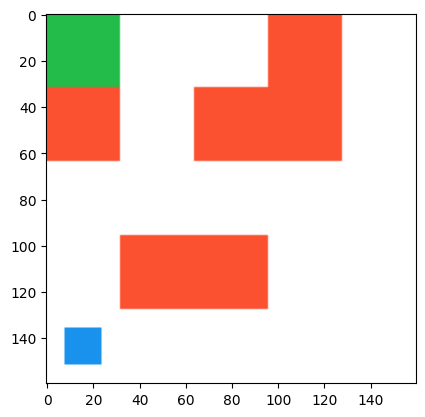

In [3]:
plt.imshow(env.render())

In [68]:
#@markdown Test with asserts that the environment dynamics behave correctly. DO NO CHANGE THIS CODE, simply run it before submitting
P1_1_PASS = False
assert len(env.reset()) == 2, "should return obs and info"
assert (env.unwrapped.agent_pos == np.array([0, 0])).all()

env.action_space.seed(1)
env.step(env.action_space.sample())
env.step(env.action_space.sample())
assert (env.unwrapped.agent_pos == np.array([1, 0])).all()

env.reset()
env.action_space.seed(1)
for _ in range(20):
    obs, _, terminated, truncated, info = env.step(2)
assert truncated == True, "time limit not working"

env.reset()
env.action_space.seed(1)
obs, rew1, terminated, truncated, info = env.step(0)
obs, rew1, terminated, truncated, info = env.step(1)
assert terminated == True, "termination not working"

env.reset()
env.action_space.seed(1)
env.unwrapped.agent_pos = env.unwrapped.goal_pos.copy()
obs, rew2, terminated, truncated, info = env.step(0)
assert terminated == False, "termination at goal not working. should not terminated at goal"

assert rew2 > rew1, "it seems the reward of the agent landing on a goal is smaller than landing on lava. This reward function is very likely wrong and won't work."
print("Environment is implemented correctly!")
P1_1_PASS = True

Environment is implemented correctly!


A general environment loop looks like the below. We constantly sample actions whether randomly via the action space object or via a policy (we will make one later). An environment needs to be reset when either terminated or truncated are True, meaning either the agent has failed (hit lava) or has won (reached the goal). Ultimately the reward determines how well the agent is doing. The code also saves the first 20 frames as a video that you can watch with the tools shown below

In [69]:
env.reset()
imgs = []
imgs.append(env.render())
for i in range(20):
    obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
    imgs.append(env.render())
    done = terminated or truncated
    if done:
        env.reset()
        imgs.append(env.render())
record_episode(imgs[:20], "result.mp4")

In [75]:
display_video("result.mp4")

### Problem 1.2: Learning to play AvoidLava with Tabular Q-Learning (5 pts)

Here you have to implement a simple Q-Learning algorithm to learn to play the game.

It is up to you to figure how to implement the algorithm from course lecture(s) in code below, some of the skeleton has already been made for you. You get full points for working code implementation that results in a successful evaluation of the agent.

The solution implementation with lightly tuned hyperparameters took around 40,000 update iterations of Q-Learning / 5 seconds of time to learn to be able to solve the game from any starting agent position (despite only ever resetting to the same initial agent position).


In [71]:
from tqdm.notebook import tqdm
env = AvoidLava(render_mode="rgb_array")
env = gym.wrappers.TimeLimit(env, max_episode_steps=20)

### your code goes below ###
# Create an appropriate matrix (recommended) or dictionary below so that you can query and set Q(S, A), the state-action value. ###
# Be wary about what the shape of the matrix should be, it should encapsulate all possible observation (state), action pairs
ACTION_SPACE = env.action_space.n
STATE_SPACE = env.unwrapped.map_size ** 2
q_mat = np.zeros((STATE_SPACE, ACTION_SPACE))

def state_to_index(state, map_size=5):
    """
    map from state to index
    """
    x, y = state
    return x * map_size + y

def index_to_state(index, map_size=5):
    """
    map from index to state
    """
    x = index // map_size
    y = index % map_size
    return np.array([x, y])

### your code goes above ###

np.random.seed(0)
env.action_space.seed(0)
obs, _ = env.reset() # obs is s_0

# Hyperparameters of Q-Learning algorithm
step_size = 0.25
discount = 0.95
N = 40000
epsilon_start = 0.9  # initial eps
epsilon_end = 0.05   # min eps
epsilon_decay = 0.9995  # eps decay rate
epsilon = epsilon_start

# Epsilon-greedy to select action
def epsilon_greedy(q_mat, state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(q_mat[state_to_index(state)])

for i in tqdm(range(N)):
    ### your code goes below ###
    # Write an action sampling strategy from lecture or make up your own ###
    # You may not implement a ground truth action sampler (e.g. BFS)
    # You may not modify environment state directly of env, you can only use env.step and env.reset
    
    ### your code goes above ###
    obs, _ = env.reset()
    done = False
    
    while not done:
        # use epsilon-greedy to select action
        action = epsilon_greedy(q_mat, obs, epsilon)
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # TD update
        if not done:
            td_target = reward + discount * np.max(q_mat[state_to_index(next_obs)])
        else:
            td_target = reward
        td_error = td_target - q_mat[state_to_index(obs), action]
        q_mat[state_to_index(obs), action] += step_size * td_error
        obs = next_obs

        ### your code goes below ###
        # Implement TD(0) learning here by updating the value function (otherwise known as q_mat as a tabular form)
        # Hints: obs is s_t, next_obs is s_{t+1}

        ### your code goes above ###
        
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

  0%|          | 0/40000 [00:00<?, ?it/s]

### Problem 1.3: Visualizing the RL Agent

This section has code to be filled out to visualize the behavior of the greedy RL agent acting on a trained Q function as well as visualize what the Q function has learned via a saliency map.

#### Visualization of Q Function (1pt):

Visualize the Q Function as a heatmap of the game map with cell value equal to $\max_a {Q(s, a)}$ for cell $s$ in the map (it should be 5x5). You may or may not need to invert the y-axis, the map should resemble the actual gamemap in a way. You may find it interesting to also look at how your q function evolves during the course of training.

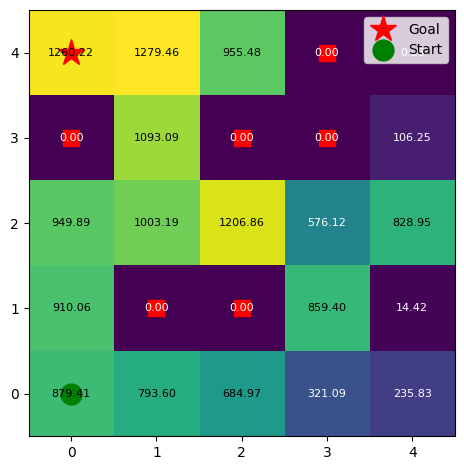

In [82]:
fig, ax = plt.subplots(1, 1)

### your code goes below ###
# get max q value for each state
max_q_values = np.max(q_mat, axis=1)
heatmap = np.zeros((env.unwrapped.map_size, env.unwrapped.map_size))
# fill heatmap 
for state_idx in range(STATE_SPACE):
    x, y = index_to_state(state_idx)
    # invert y axis
    heatmap[y, x] = max_q_values[state_idx]


im = ax.imshow(heatmap, cmap='viridis', origin='lower')

# add text annotations
for i in range(heatmap.shape[0]):  
    for j in range(heatmap.shape[1]):  
        value = heatmap[i, j]
        ax.text(j, i, f"{value:.2f}", ha='center', va='center', 
                color='white' if value < heatmap.max() / 2 else 'black', 
                fontsize=8)

# mark start and goal
ax.plot(0, 4, 'r*', markersize=20, label='Goal')  
ax.plot(0, 0, 'go', markersize=15, label='Start')
ax.legend()

# mark lava positions
for lava_pos in DEFAULT_LAVA_MAP:
    ax.plot(lava_pos[0], lava_pos[1], 'rs', markersize=12)

ax.set_xticks(np.arange(env.unwrapped.map_size))
ax.set_yticks(np.arange(env.unwrapped.map_size))

### your code goes above ###
fig.tight_layout()
fig.savefig("P2_3.png")
plt.show()

#### Evaluation videos from different starting positions (1pt):

Using your trained Q function from earlier, fill in the code below to generate 3 videos of your agent playing the game. It must be trained sufficiently long enough such that in all trials below it solves the game each time. An `assert` is placed to check if the agent solved the task or not.

In [86]:
for trial, start_pos in enumerate([(0, 0), (3, 0), (4, 3)]):
    obs, _ = env.reset()
    env.unwrapped.agent_pos = np.array(start_pos) # not good RL practice but for the purpose of homework we set it like this
    obs = env.unwrapped.get_obs()
    imgs = []
    imgs.append(env.render())

    ### your code goes below ###
    # Using the environment loop and your q function, record videos of your agents
    # behavior below with the agent in different starting positions.
    for i in range(20):
        # check if the agent has reached the goal
        if np.array_equal(obs, env.unwrapped.goal_pos):
            print(f"Trial {trial}: Reached goal at step {i}")
            imgs.append(env.render())
            break
        # get action from q table
        action = np.argmax(q_mat[state_to_index(obs)])
        obs, rew, terminated, truncated, info = env.step(action)
        imgs.append(env.render())
        done = terminated or truncated
        if done:
            env.reset()
            imgs.append(env.render())
            break

    ### your code goes above ###

    record_episode(imgs, f"p_1_3_trial_{trial}.mp4")
    # do not remove the assert here
    assert (env.unwrapped.agent_pos == env.unwrapped.goal_pos).all(), "agent was not succesful"

Trial 0: Reached goal at step 6
Trial 1: Reached goal at step 9
Trial 2: Reached goal at step 7


In [87]:
display_video("p_1_3_trial_0.mp4")

In [90]:
display_video("p_1_3_trial_1.mp4")

In [91]:
display_video("p_1_3_trial_2.mp4")

## 2 Deep Reinforcement Learning (10 pts)

This section will take you through the basics of deep reinforcement learning and how we evolve from tabular learning methods done in section 2 to more modern deep RL methods that can solve far more complex environments.

We will tackle a classic control problem known as CartPole via a Deep Q-Network. The objective is to move the cart left/right to keep the pole upright and not to let it fall.

Note that this environment has a different setup compared to the lava game, and further more its default time limit is 500 steps compared to the 20 we used for the lava game (this long time limit may be something of note for DQN training)

Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space: Discrete(2)


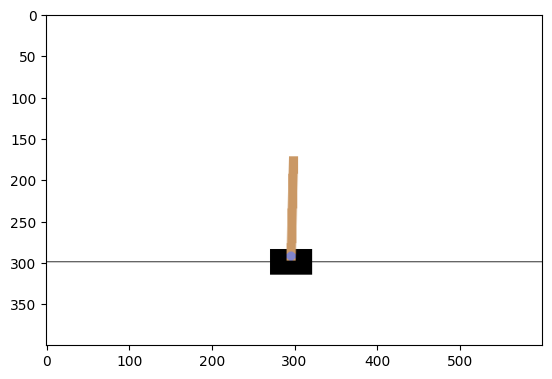

In [93]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)
plt.imshow(env.render())

Notably the observation space is continuous (Box space), meaning tabular methods will likely struggle / are non-trivial to write. This is where deep learning shines, neural networks are great function approximators and overfitting seen data, we can use those to replace our previous matrix-table backed Q function in Problem 1.

### Problem 2.1 Building the Neural Nets (2pts)

We will use PyTorch for this course, first implement a basic neural network with PyTorch that can take in observations from the gym environment, pass it through a deep network and generate a scalar value for every possible discrete action representing a predicted Q value.

A GPU is not necessary here, it will run very fast.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class QNet(nn.Module):
    ### your code goes below ###
    def __init__(self):
        super().__init__()

    def forward(self, obs):
        pass

    ### your code goes above ###

In [ ]:
# quick sanity test
P2_1_PASS = False
q_function = QNet()
obs, _ = env.reset()
obs = torch.from_numpy(obs)
assert q_function(obs).shape == (2, )
P2_1_PASS = True

### Problem 2.2 Building a ReplayBuffer (2pts)

Fundamental to DQN and many modern deep RL algorithms is the replay buffer, a object to effectively hold past seen environment transitions to then train on in the future. Implement the code below to enable insertion of environment transition data (observation, next_observation, action, reward, done) and sampling batches of data for training.

If you aren't sure about the shapes, play around with env.step() return values. Note that `done = terminated or truncated`.

In [ ]:
class ReplayBuffer:
    def __init__(self, buffer_size: int, obs_space: gym.spaces.Space, action_space: gym.spaces.Space):
        self.buffer_size = buffer_size

        ### your code goes below ###
        # You may want to add code here to initialize some things

        ### your code goes above ###

    def store(self, obs, next_obs, reward, action, done):
        ### your code goes below ###

        ### your code goes above ###
        return

    def sample(self, batch_size: int):
        obs, next_obs, rewards, actions, dones = None, None, None, None, None
        ### your code goes below ###
        # Should return a batch of observations, next_obs, rewards, actions, and dones as a tuple

        ### your code goes above ###
        return torch.from_numpy(obs).float(), torch.from_numpy(next_obs).float(), torch.from_numpy(rewards).float(), torch.from_numpy(actions), torch.from_numpy(dones)

In [ ]:
# quick sanity check for ReplayBuffer
P2_2_PASS = False
buffer = ReplayBuffer(4, env.observation_space, env.action_space)
obs, _ = env.reset()
action = env.action_space.sample()
for _ in range(5):
    next_obs, reward, terminated, truncated, _ = env.step(action)
    buffer.store(obs, next_obs, reward, action, terminated or truncated)
    obs = next_obs
b_obs, b_next_obs, b_rewards, b_actions, b_dones = buffer.sample(batch_size=2)
assert b_obs.shape == (2, *obs.shape), b_next_obs.shape == (2, *obs.shape)
assert b_rewards.shape == (2, )
assert b_actions.shape == (2, )
P2_2_PASS = True

### Problem 2.3: DQN Training (6pts)
Your task here is to implement code below to train a Deep Q Network (DQN). DQN isn't explicitly covered in lecture but we describe the pseudocode below which should have aspects that look similar to lecture content

DQN
1. Initialize the replay buffer $D$ and Q network $Q$ with two sets of weights, $\theta$ and $\theta'$ which are initially equal. $\theta$ is the behavior policy's weights, and $\theta'$ is for the target network.
2. At each environment timestep:
    1. Let $s$ be the current state/observation. With probability $\epsilon$ sample a random action $a$. Otherwise greedily select $a = \arg \max_a Q_\theta(s, a)$
    2. Execute $a$ in the environment and receive reward $r$ and next state/observation $s'$.
    3. Add transition $(s, a, s', r)$ to $D$.
    4. Every $i$ environment steps (the behavior network update frequency), sample batch from $D$ and compute the TD loss. The TD loss is defined as $TD_\theta(s, a, s', r)= ||Q_\theta(s, a) - [r + \gamma_{a'} \max Q'_\theta (s', a')]||^2$.
    5. Note that in practice, environments might terminate/truncate (when env is done). In those situations the $\gamma_{a'} \max Q'_\theta (s', a')$ term should be set to 0.
    6. Perform gradient descent
    7. Every $j$ environment steps (the target network update frequency), set $\theta'$ equal to $\theta$.
    8. Update $\epsilon$ (typically to smaller and smaller values to encourage agent to take more greedy actions over time).






Training should generally take about a minute if implemented correctly and using not too large of a neural network and training batch size.

Part of this task is to have a general understanding of how to tune RL algorithms, it is a highly practical skill to have for future projects and robot learning in general, especially since RL algorithms are often very black-box. The given hyperparameters are not tuned. They will work, but you will need to modify them a little in order to train a strong enough agent.

In [ ]:
np.random.seed(3)
torch.manual_seed(3)
### your code goes below ###
# tune these hyperparameters, the ones provided work but train slowly
buffer_size = 32
batch_size = 4
discount = 0.99
learning_starts = buffer_size
training_iterations = 50_000 # for grading, this may not be changed
learning_rate = 2.5e-4
behavior_net_update_freq = 10
target_net_update_freq = 500
### your code goes above ###

# Create a training env and eval env
env = gym.make("CartPole-v1")
eval_env = gym.make("CartPole-v1", render_mode="rgb_array")

# Create behavior net and target net
behavior_net = QNet()
target_net = QNet()
target_net.load_state_dict(behavior_net.state_dict())
optimizer = optim.Adam(behavior_net.parameters(), lr=learning_rate)

# Create replay buffer
buffer = ReplayBuffer(buffer_size, env.observation_space, env.action_space)

def evaluate(save_video: str = None):
    # Evaluates the current agent and report the return and episode length
    eps_ret = 0
    eps_len = 0
    done = False
    obs, _ = eval_env.reset()
    imgs = []
    while not done:
        obs, rew, terminated, truncated, info = eval_env.step(behavior_net(torch.from_numpy(obs)).argmax().cpu().numpy())
        if save_video is not None:
            imgs.append(eval_env.render())
        eps_ret += rew
        eps_len += 1
        done = terminated or truncated
        if done:
            break
    if save_video is not None:
        record_episode(imgs, save_video, fps=60)
    return eps_ret, eps_len

def get_epsilon(step):
    ### your code goes below ###
    # Implement a custom schedule to reduce epsilon over time so that the RL agent
    # takes greedy actions more often
    epsilon = 0
    ### your code goes above ###
    return epsilon

pbar = tqdm(range(training_iterations))

obs, _ = env.reset()
for step in pbar:
    ### your code goes below ###
    # sample actions
    action = env.action_space.sample()
    ### your code goes above ###

    next_obs, reward, termination, truncation, info = env.step(action)
    done = termination or truncation

    # store data and reset env if necessary
    buffer.store(obs, next_obs, reward, action, done)
    obs = next_obs
    if done:
        obs, _ = env.reset()

    if step > learning_starts:
        if step % behavior_net_update_freq == 0:
            b_obs, b_next_obs, b_rewards, b_actions, b_dones = buffer.sample(batch_size)
            ### your code goes below ###
            # Implement the training code for optimizing the behavior network, you will need
            # to leverage the target network to ensure training stability.
            # Careful to note that in this homework for good performance you should ensure you don't
            # create a temporal difference target that includes discounted values if it is the final frame (check via b_dones)
            pass
            ### your code goes above ###

        if step % target_net_update_freq == 0:
            ### your code goes below ###
            # Implement the code to copy the target network. Aren't sure what to do? Check pytorch documentation!
            pass
            ### your code goes above ###

    # every 10000 iterations evaluate once and save a video
    if step % 10_000 == 0:
        eval_eps_ret, eval_eps_len = evaluate(save_video=f"cartpole_videos/{step}.mp4")
        pbar.set_postfix(dict(eval_eps_ret=eval_eps_ret, eval_eps_len=eval_eps_len, epsilon=get_epsilon(step)))
        print(f"step: {step}, eval_eps_ret: {eval_eps_ret}")


  0%|          | 0/50000 [00:00<?, ?it/s]

step: 0, eval_eps_ret: 9.0
step: 10000, eval_eps_ret: 207.0
step: 20000, eval_eps_ret: 298.0
step: 30000, eval_eps_ret: 147.0
step: 40000, eval_eps_ret: 398.0


In [ ]:
eval_env.reset(seed=0)
avg_ret = 0
trials = 20
for trial in range(trials):
    ret, _ = evaluate()
    avg_ret += ret
avg_ret /= trials
print("Average Return: ", avg_ret)
assert avg_ret >= 400, f"agent does not perform well enough. Average return is {avg_ret} < 400, tune the hyperparameters/make sure DQN is implemented correctly"
P2_3_RET = avg_ret

In [ ]:
display_video("cartpole_videos/40000.mp4")

# 3 Submission

If you are taking the CSE 276F course at UC San Diego, to submit your work please save this .ipynb file locally first. Then run the cells below which zips up some of your answers and generated evaluation images/videos for grading.

In [ ]:
work_data = {
    "p1_1": P1_1_PASS,
    "p2_1": P2_1_PASS,
    "p2_2": P2_2_PASS,
    "p2_3": P2_3_RET
}
import json
with open("answers.json", 'w') as json_file:
    json.dump(work_data, json_file, indent=2)

In [ ]:
!mkdir -p hw_files/p1.3 2> /dev/null
!cp P2_3.png hw_files/
!cp cartpole_videos/40000.mp4 hw_files/
!cp answers.json hw_files/
!cp p_1_3_trial_*.mp4 hw_files/p1.3
!tar -czvf hw_files.tar.gz hw_files > /dev/null